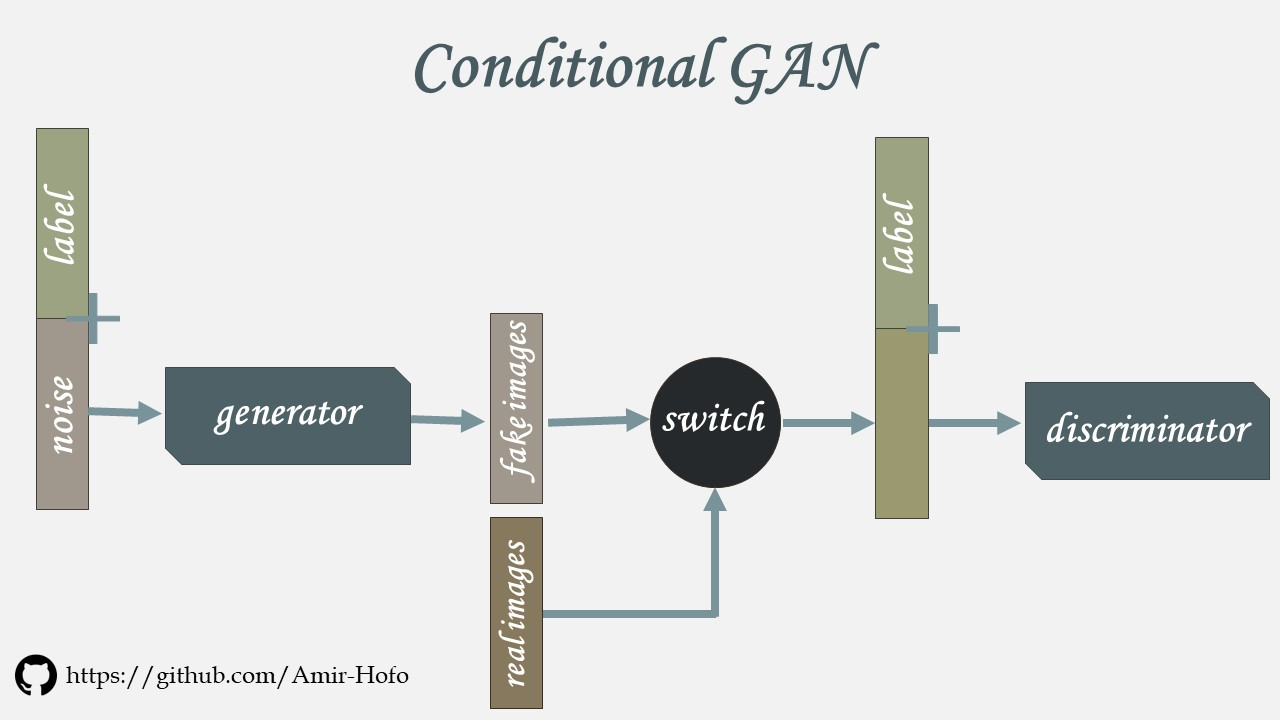

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from torchvision import transforms as T 
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image

## data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch size: 100 , num of batch: 700


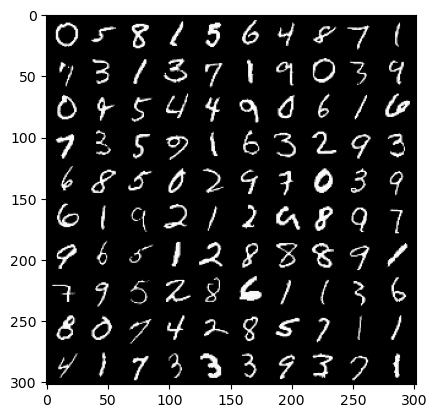

In [3]:
# transform
transform_data= T.Compose([T.ToTensor(),
                           T.Normalize(mean= 0.5,
                                        std= 0.5) ])

# load or download MNIST dataset
train_dataset= MNIST(root='',
        train= True,
        transform= transform_data,
        download= True)

valid_dataset= MNIST(root='',
        train= False,
        transform= transform_data,
        download= True)

# concat dataset
dataset= ConcatDataset([train_dataset, valid_dataset])

# data loader
data_batch_size= 100

data_loader= DataLoader(dataset, 
                         batch_size= data_batch_size, 
                         shuffle=True)

print("batch size:",data_loader.batch_size,
     ", num of batch:", len(data_loader))

# show a sample of images of a batch
x,_= next(iter(data_loader))
img_grid= make_grid(x, 10)
plt.imshow(img_grid.permute(1,2,0))

## model

In [4]:
# setting model parameters
device= 'cuda' if torch.cuda.is_available() else 'cpu'
image_channel= x.shape[1] 
h= x.shape[2]
w= x.shape[3]
z_dim= h
num_class= 2 
num_classes_data= 10
fc_neuron= 256

In [5]:
# generator model
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1= nn.LazyLinear(fc_neuron)
        self.fc2= nn.LazyLinear(fc_neuron*2)
        self.fc3= nn.LazyLinear(fc_neuron*3)
        self.fc4= nn.LazyLinear(h*w)
        
    def forward(self,x):
        y= F.leaky_relu(self.fc1(x), negative_slope= 0.2)
        y= F.leaky_relu(self.fc2(y), negative_slope= 0.2)
        y= F.leaky_relu(self.fc3(y), negative_slope= 0.2)
        y= F.tanh(self.fc4(y))
        return y

# discriminator model
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1= nn.LazyLinear(3*fc_neuron)
        self.fc2= nn.LazyLinear(2*fc_neuron)
        self.fc3= nn.LazyLinear(fc_neuron)
        self.fc4= nn.LazyLinear(1)
        
    def forward(self,x):
        y= F.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.2), 
                     p= 0.3)
        y= F.dropout(F.leaky_relu(self.fc2(y), negative_slope= 0.2),
                    p= 0.3)
        y= F.dropout(F.leaky_relu(self.fc3(y), negative_slope= 0.2),
                    p= 0.3)
        y= F.sigmoid(self.fc4(y))
        return y

# definition of models    
gen_model= generator()
dis_model= discriminator()

# loss & optim
eta= 0.0002
loss_fn= nn.BCELoss().to(device)
optimizer_gen= optim.Adam(gen_model.parameters(), lr= eta)
optimizer_dis= optim.Adam(dis_model.parameters(), lr= eta)

C:\Users\amir\.conda\envs\deepLearning2022\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## one epoch train

In [7]:
def train_one_epoch(dis_model, gen_model, train_loader,
                    loss_fn, optimizer_dis, optimizer_gen):
    dis_model.train()
    gen_model.train()
    
    for i, (x_real, y) in enumerate(train_loader):
        batch_size= x_real.shape[0]
        one_hot = torch.nn.functional.one_hot(y, num_classes_data)
        
        ## Disciminator
        #  real data
        x_real= x_real.flatten(1).to(device)
        y_real= torch.ones(batch_size, 1).to(device)
        concat_data_dis_real= torch.cat((one_hot, x_real), dim=1)
        out_real= dis_model(concat_data_dis_real)
        loss_real= loss_fn(out_real, y_real)
        
        # fake data
        noise= torch.randn(batch_size, z_dim).to(device)
        concat_data_gen_fake= torch.cat((one_hot, noise), dim=1)
        x_fake= gen_model(concat_data_gen_fake)
        concat_data_dis_fake= torch.cat((one_hot, x_fake), dim=1)
        y_fake= torch.zeros(batch_size, 1).to(device)
        out_fake= dis_model(concat_data_dis_fake)
        loss_fake= loss_fn(out_fake, y_fake)
        
        # optim
        loss_dis= loss_real+ loss_fake
        loss_dis.backward()
        optimizer_dis.step()
        optimizer_dis.zero_grad()
        gen_model.zero_grad()
        
        ## Generator
        noise= torch.randn(batch_size, z_dim).to(device)
        concat_data_gen= torch.cat((one_hot, noise), dim=1)
        out_gen= gen_model(concat_data_gen)
        lable_gen= torch.ones(batch_size, 1).to(device)
        concat_data_dis_for_gen= torch.cat((one_hot,out_gen), dim=1)
        out_dis= dis_model(concat_data_dis_for_gen)
        
        # optim
        loss_gen= loss_fn(out_dis, lable_gen)
        loss_gen.backward()
        optimizer_gen.step()
        optimizer_gen.zero_grad()
        dis_model.zero_grad()
        
    return dis_model, gen_model

## training & output

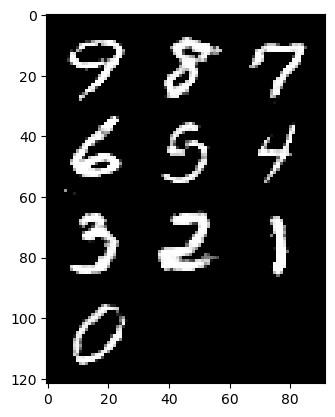

In [40]:
# model training
num_epochs = 800
for epoch in range(num_epochs):
    dis_model, gen_model= train_one_epoch(dis_model, gen_model, 
                                          data_loader, loss_fn, 
                                          optimizer_dis, optimizer_gen)
    
    # creating images of numbers one to ten
    target_label= torch.tensor(range(num_classes_data))
    outputs= torch.zeros(2, image_channel, h, w)
    for number in target_label:
        with torch.no_grad():
            bs= 1
            z_test= torch.randn(bs, z_dim).to(device)
            target_onehot= torch.nn.functional.one_hot(number, num_classes_data)
            target_onehot= torch.unsqueeze(target_onehot, dim=0)
            concat_target_data= torch.cat((target_onehot, z_test), dim=1)
            output= torch.unsqueeze(gen_model(concat_target_data), dim=0)
            outputs= torch.cat((output.view(bs,image_channel, h, w), 
                                outputs), dim=0)

    # display the created images
    img_grid= make_grid(outputs, 3)
plt.imshow(img_grid.permute(1,2,0))